<div class="alert alert-block alert-danger">

#### Student Name: Anon Pipatpakin
#### Student ID: 33366829
# Logistic Regression versus Bayes Classifier

</div>

<div class="alert alert-block alert-info">
    
## Libaries

</div>

In [1]:
# Import libaries
from sklearn.base import BaseEstimator
from scipy.spatial import KDTree
import numpy as np
from sklearn.datasets import load_diabetes, fetch_california_housing
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss, log_loss
from scipy.stats import multivariate_normal
import warnings

<div class="alert alert-block alert-info">
    
## Table of Contents

</div>

[1. Qestion 7](#Question7) <br>

<div class="alert alert-block alert-success">
    
## Question 7  <a class="anchor" name="Question7"></a>

**I.** Load the breast cancer dataset via load breast cancer in sklearn.datasets, import
LogisticRegression from sklearn.linear model, and copy the code from Activity 3.3.
for the Bayes classifier (BC). For the Bayes classifier consider the Naive Bayes variant (without shared covariance) as well as the variants with full covariance (shared and not shared).
Perform a training/test split (with train size equal to 0.8) and report which of the models
performs best in terms of train and test performance.
Note: for logistic regression you can also use the code for the variant with regularisation from
Activity 3.2, but this option requires a more careful calibration of the classifier parameters
(batch size, max iterations and error tolerance).

In [2]:
class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

In [3]:
breast_cancer = load_breast_cancer()
features = breast_cancer.data
target = breast_cancer.target

In [4]:
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=1, train_size= 0.8)

Logistic zero-one loss training: 0.03736263736263734
Logistic zero-one loss testing: 0.052631578947368474
NB zero-one loss training: 0.0703296703296703
NB zero-one loss testing: 0.07894736842105265
BC (shared) zero-one loss training: 0.03956043956043953
BC (shared) zero-one loss testing: 0.052631578947368474
BC zero-one loss training: 0.06373626373626373
BC zero-one loss testing: 0.07017543859649122


C:\Users\non_n\conda\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


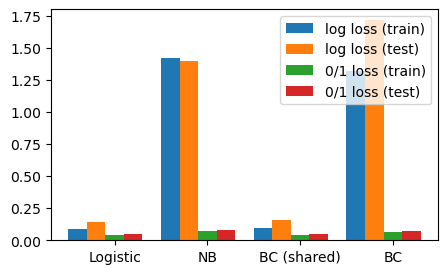

In [5]:
def plot_model_performances(models, model_names, x_train, y_train, x_test, y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))
        
        print(f'{model_names[i]} zero-one loss training: {train_01_losses[i]}')
        print(f'{model_names[i]} zero-one loss testing: {test_01_losses[i]}')


    xx = np.arange(len(models))
    bar_width = 1/(len(models)+1)
    group_width = len(models)*bar_width
    plt.bar(xx-group_width/2, train_log_losses, width=bar_width, label='log loss (train)')
    plt.bar(xx-group_width/2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 +3*bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)


logistic = LogisticRegression(max_iter=10000).fit(x_train, y_train)
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)

models = [logistic, nb, bc_shared, bc]
model_names = ['Logistic', 'NB', 'BC (shared)', 'BC']

plt.subplots(1, 1, figsize=(5, 3))
plot_model_performances(models, model_names, x_train, y_train, x_test, y_test)
plt.legend()
plt.show()

**Answer**

From the plot, we can see that the Bayes Classifier with shared covariance provides lowest on both training and testing errors.

-----------------------

**II.**
 Implement an experiment where you test the performance for increasing training sizes of
N = 5, 10, . . . , 500. For each N sample 10 training sets of the corresponding size, fit all
models, and record training and test errors.
Hints: You can use training test split from sklearn.model selection with an integer
parameter for train size (do not forget to use shuffle=True). Again make the repetitions
the inner loop to assure that  all models are trained on the same training set for a given
repetition and sample size.

In [6]:
# training size
N = list(range(5, 505, 5))

In [7]:
warnings.filterwarnings('ignore')

In [8]:
num_rep = 10

# Create arrays to store MSE values
bc_shared_train_01 = np.zeros((num_rep, len(N)))
bc_shared_test_01 = np.zeros((num_rep, len(N)))

bc_train_01 = np.zeros((num_rep, len(N)))
bc_test_01 = np.zeros((num_rep, len(N)))

nb_train_01 = np.zeros((num_rep, len(N)))
nb_test_01 = np.zeros((num_rep, len(N)))

logistic_train_01 = np.zeros((num_rep, len(N)))
logistic_test_01 = np.zeros((num_rep, len(N)))



for rep in range(num_rep):
    for i,sample_size in enumerate(N):
        x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle=True, train_size=sample_size, random_state=rep)
        
        bc_shared= BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
        bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)
        nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
        logistic = LogisticRegression().fit(x_train, y_train)
        
        bc_shared_train_01[rep, i] = zero_one_loss(y_train, y_pred=bc_shared.predict(x_train))
        bc_shared_test_01[rep, i] = zero_one_loss(y_test, y_pred=bc_shared.predict(x_test))
        
        bc_train_01[rep, i] = zero_one_loss(y_train, y_pred=bc.predict(x_train))
        bc_test_01[rep, i] = zero_one_loss(y_test, y_pred=bc.predict(x_test))

        nb_train_01[rep, i] = zero_one_loss(y_train, y_pred= nb.predict(x_train))
        nb_test_01[rep, i] = zero_one_loss(y_test, y_pred= nb.predict(x_test))

        logistic_train_01[rep, i] = zero_one_loss(y_train, y_pred= logistic.predict(x_train))
        logistic_test_01[rep, i] = zero_one_loss(y_test, y_pred= logistic.predict(x_test))
        

In [9]:
# calculate mean of 0 1 loss for each sample size
bc_shared_train_error = np.mean(bc_shared_train_01, axis=0)
bc_shared_test_error = np.mean(bc_shared_test_01, axis=0)

bc_train_error = np.mean(bc_train_01, axis=0)
bc_test_error = np.mean(bc_test_01, axis=0)

nb_train_error = np.mean(nb_train_01, axis=0)
nb_test_error = np.mean(nb_test_01, axis=0)

logistic_train_error = np.mean(logistic_train_01, axis=0)
logistic_test_error = np.mean(logistic_test_01, axis=0)

In [10]:
# calculate differences between training and testing
bc_shared_gap = np.abs(bc_shared_test_error - bc_shared_train_error)
bc_gap = np.abs(bc_test_error - bc_train_error)
nb_gap = np.abs(nb_test_error - bc_train_error)
logistic_gap = np.abs(logistic_test_error - logistic_train_error)


--------------------------

**III.** Create suitable plots that compare the mean train and test performances of all models as a
function of training size. There is no need to include error bars if that makes the plot too
hard to read.

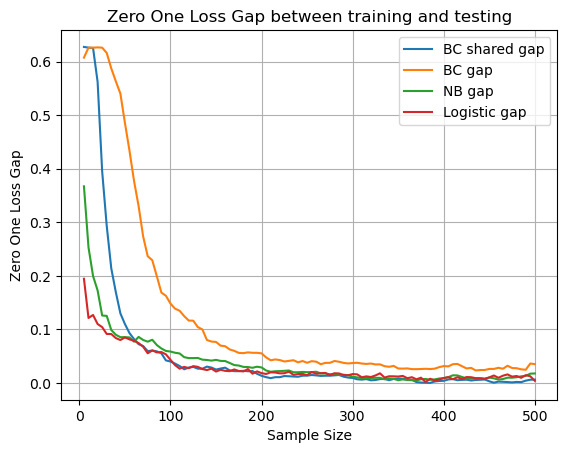

In [11]:
# generalisation gap 
plt.plot(N, bc_shared_gap, label='BC shared gap')

plt.plot(N, bc_gap, label='BC gap ')
plt.plot(N, nb_gap, label='NB gap')

plt.plot(N, logistic_gap, label='Logistic gap')

         
plt.xlabel('Sample Size')
plt.ylabel('Zero One Loss Gap')
plt.legend()
plt.title('Zero One Loss Gap between training and testing')
plt.grid()
plt.show()

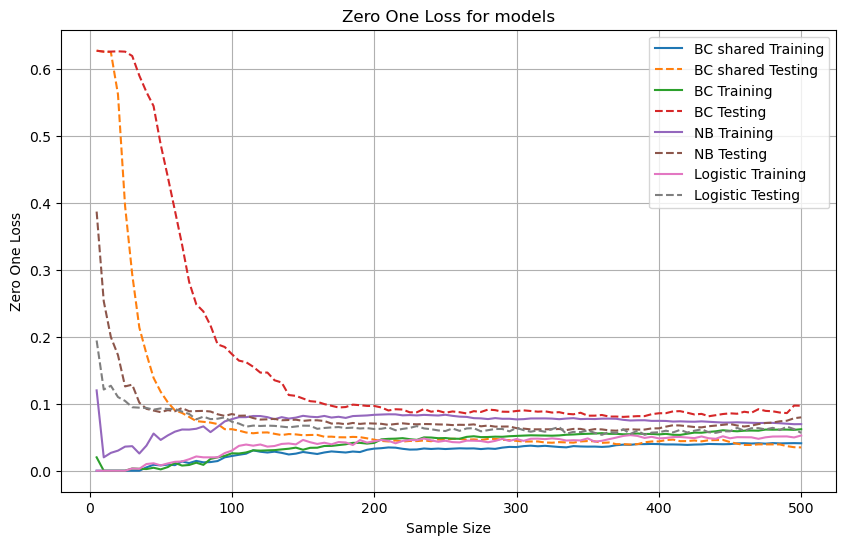

In [12]:
# train test errors
plt.figure(figsize=(10, 6))
plt.plot(N, bc_shared_train_error, label='BC shared Training')
plt.plot(N, bc_shared_test_error, label='BC shared Testing', linestyle= '--')

plt.plot(N, bc_train_error, label='BC Training')
plt.plot(N, bc_test_error, label='BC Testing', linestyle= '--')

plt.plot(N, nb_train_error, label='NB Training ')
plt.plot(N, nb_test_error, label='NB Testing', linestyle= '--')

plt.plot(N, logistic_train_error, label='Logistic Training ')
plt.plot(N, logistic_test_error, label='Logistic Testing', linestyle= '--')

plt.xlabel('Sample Size')
plt.ylabel('Zero One Loss')
plt.legend()
plt.title('Zero One Loss for models')
plt.grid()
plt.show()

------------------------

**IV.** Formulate answers to the following questions:

**Answer**

**a.** What happens to each classifiers train and test performance when the number of training
data points is increased?

**Train error:** When training dataset is small, all models tend to have low training errors. As the training dataset increases, training errors slightly increase.

**Test error:** With a small training dataset, test errors of all models have high test errors. After training models with larger training dataset, test errors decreases significantly and become more steady after particular sample sizes.


**b.** Which classifier is best suited when the training set is small, and which is best suited
when the training set is big?

**Small training dataset:** With a small training dataset, logistic regression model provides the best test error result with the least generalizaed gap.

**Large training dataset:** When training dataset is large, models have low testing errors. The Bayesian with shared covarince matrix provides the lowest testing error.

**c.** Justify your observations by providing some speculations and possible reasons.
Hint: Think about model complexity and the fundamental concepts of machine learning
covered in Module 1. In particular think of the number of parameters that each model has to
learn and what assumptions the models make about the data which could be violated.


Consider parameters that each model needs to learn, we can rank the number of parameters from low to high(low complexity to high complexity) as follow:
1. Logistic regression
2. Naive Bayes 
3. Bayes Classifier with shared covariance matrix
4. Bayes Classifier without shared covariance matrix

With small training dataset, models with high complexity tend to fit training dataset very well(low bias), but have poor predictive performances on testing dataset(high variance). In contrast, logistic regression has less parameters will be less flexible, so it will have high bias and low variance. 

In term of assumtions, the training and testing datasets might not from the multivariate gaussian distribution or might not shared the same covarice matrix.